In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np


In [21]:
# Librerías
import pandas as pd
import numpy as np


movies_path = "ml-1m/movies.dat"
ratings_path = "ml-1m/ratings.dat"
users_path = "ml-1m/users.dat"


# Carga de los datos
users = pd.read_csv(users_path, sep="::", engine="python", names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding="latin-1")
movies = pd.read_csv(movies_path, sep="::", engine="python", names=["MovieID", "Title", "Genres"], encoding="latin-1")
ratings = pd.read_csv(ratings_path, sep="::", engine="python", names=["UserID", "MovieID", "Rating", "Timestamp"], encoding="latin-1")

# Mostrar primeras filas
ratings.head()



,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [22]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings['user'] = user_encoder.fit_transform(ratings['UserID'])
ratings['movie'] = movie_encoder.fit_transform(ratings['MovieID'])

# Guardamos número de usuarios y películas únicos
num_users = ratings['user'].nunique()
num_movies = ratings['movie'].nunique()

num_users, num_movies


(6040, 3706)

In [23]:
# Obtener lista única de géneros
movies['Genres'] = movies['Genres'].str.split('|')
all_genres = sorted(set(g for sublist in movies['Genres'] for g in sublist))
genre_to_idx = {genre: idx for idx, genre in enumerate(all_genres)}

# Crear codificación multi-hot para cada película
def encode_genres(genres_list):
    multi_hot = np.zeros(len(genre_to_idx), dtype=np.float32)
    for genre in genres_list:
        if genre in genre_to_idx:
            multi_hot[genre_to_idx[genre]] = 1.0
    return multi_hot

movies['genre_vector'] = movies['Genres'].apply(encode_genres)


In [24]:
from sklearn.preprocessing import LabelEncoder

# Fusionar ratings con info del usuario
ratings_full = ratings.merge(users, on="UserID")

# Codificar gender (F/M → 0/1 por ejemplo)
gender_encoder = LabelEncoder()
ratings_full['gender'] = gender_encoder.fit_transform(ratings_full['Gender'])

# Codificar age y occupation como categorías
age_encoder = LabelEncoder()
occ_encoder = LabelEncoder()

ratings_full['age'] = age_encoder.fit_transform(ratings_full['Age'])
ratings_full['occupation'] = occ_encoder.fit_transform(ratings_full['Occupation'])

# Mostrar las clases para documentar
print("Géneros:", gender_encoder.classes_)
print("Edades:", age_encoder.classes_)
print("Ocupaciones:", occ_encoder.classes_)

ratings_full[['user', 'movie', 'Rating', 'gender', 'age', 'occupation']].head()


Géneros: ['F' 'M']
Edades: [ 1 18 25 35 45 50 56]
Ocupaciones: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


,user,movie,Rating,gender,age,occupation
0,0,1104,5,0,0,10
1,0,639,3,0,0,10
2,0,853,3,0,0,10
3,0,3177,4,0,0,10
4,0,2162,5,0,0,10


In [25]:
ratings_full = ratings_full.merge(movies[['MovieID', 'genre_vector']], on='MovieID')

ratings_full.head()

,UserID,MovieID,Rating,Timestamp,user,movie,Gender,Age,Occupation,Zip-code,gender,age,occupation,genre_vector
0,1,1193,5,978300760,0,1104,F,1,10,48067,0,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
1,1,661,3,978302109,0,639,F,1,10,48067,0,0,10,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,914,3,978301968,0,853,F,1,10,48067,0,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,3408,4,978300275,0,3177,F,1,10,48067,0,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,1,2355,5,978824291,0,2162,F,1,10,48067,0,0,10,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
class FullHybridNCF(nn.Module):
    def __init__(self, num_users, num_items, num_genders, num_ages, num_occs, num_genres,
                 embedding_dim=32, mlp_layers=[64, 32, 16], dropout=0.3):
        super(FullHybridNCF, self).__init__()

        # Embeddings usuario-película
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embedding_dim)

        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim)

        # Embeddings para metadata usuario
        self.gender_embedding = nn.Embedding(num_genders, 4)
        self.age_embedding = nn.Embedding(num_ages, 4)
        self.occ_embedding = nn.Embedding(num_occs, 4)

        # Proyección densa para género multi-hot
        self.genre_dense = nn.Linear(num_genres, 8)

        # MLP
        mlp_input_size = 2 * embedding_dim + 3 * 4 + 8  # user + item + gender/age/occ + genre info
        mlp_layers_seq = []
        for layer_size in mlp_layers:
            mlp_layers_seq.append(nn.Linear(mlp_input_size, layer_size))
            mlp_layers_seq.append(nn.ReLU())
            mlp_layers_seq.append(nn.Dropout(dropout))
            mlp_input_size = layer_size
        self.mlp = nn.Sequential(*mlp_layers_seq)

        # Capa final combinada
        self.final_layer = nn.Linear(embedding_dim + mlp_layers[-1], 1)

    def forward(self, user_ids, item_ids, gender_ids, age_ids, occ_ids, genre_vecs):
        # GMF
        gmf_user = self.user_embedding_gmf(user_ids)
        gmf_item = self.item_embedding_gmf(item_ids)
        gmf_output = gmf_user * gmf_item

        # MLP con metadata
        mlp_user = self.user_embedding_mlp(user_ids)
        mlp_item = self.item_embedding_mlp(item_ids)
        gender_emb = self.gender_embedding(gender_ids)
        age_emb = self.age_embedding(age_ids)
        occ_emb = self.occ_embedding(occ_ids)
        genre_proj = self.genre_dense(genre_vecs)

        mlp_input = torch.cat([mlp_user, mlp_item, gender_emb, age_emb, occ_emb, genre_proj], dim=-1)
        mlp_output = self.mlp(mlp_input)

        # Concatenar GMF y MLP
        final_input = torch.cat([gmf_output, mlp_output], dim=-1)
        output = self.final_layer(final_input)
        return output.squeeze()


In [27]:
class FullHybridDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['movie'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['Rating'].values, dtype=torch.float)
        self.genders = torch.tensor(df['gender'].values, dtype=torch.long)
        self.ages = torch.tensor(df['age'].values, dtype=torch.long)
        self.occs = torch.tensor(df['occupation'].values, dtype=torch.long)
        self.genres = torch.tensor(np.stack(df['genre_vector'].values), dtype=torch.float)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return (
            self.users[idx],
            self.items[idx],
            self.genders[idx],
            self.ages[idx],
            self.occs[idx],
            self.genres[idx],
            self.ratings[idx]
        )


In [28]:
from sklearn.model_selection import train_test_split

# Separar en train, val y test
train_df, test_df = train_test_split(ratings_full, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Crear datasets
train_dataset = FullHybridDataset(train_df)
val_dataset = FullHybridDataset(val_df)
test_dataset = FullHybridDataset(test_df)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)


In [29]:
def train_full_model(model, train_loader, val_loader, epochs=10, lr=0.001, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for user, item, gender, age, occ, genre_vec, rating in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            user, item = user.to(device), item.to(device)
            gender, age, occ = gender.to(device), age.to(device), occ.to(device)
            genre_vec = genre_vec.to(device)
            rating = rating.to(device)

            optimizer.zero_grad()
            prediction = model(user, item, gender, age, occ, genre_vec)
            loss = criterion(prediction, rating)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validación
        model.eval()
        val_losses = []
        with torch.no_grad():
            for user, item, gender, age, occ, genre_vec, rating in val_loader:
                user, item = user.to(device), item.to(device)
                gender, age, occ = gender.to(device), age.to(device), occ.to(device)
                genre_vec = genre_vec.to(device)
                rating = rating.to(device)

                prediction = model(user, item, gender, age, occ, genre_vec)
                val_loss = criterion(prediction, rating)
                val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}: Train MSE = {np.mean(train_losses):.4f}, Val MSE = {np.mean(val_losses):.4f}, Val RMSE = {np.sqrt(np.mean(val_losses)):.4f}")


In [31]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [32]:
# Parámetros de dimensiones
num_genres = len(genre_to_idx)

# Inicialización del modelo completo
full_model = FullHybridNCF(
    num_users=num_users,
    num_items=num_movies,
    num_genders=ratings_full['gender'].nunique(),
    num_ages=ratings_full['age'].nunique(),
    num_occs=ratings_full['occupation'].nunique(),
    num_genres=num_genres,
    embedding_dim=32,
    mlp_layers=[64, 32, 16],
    dropout=0.3
).to(device)


In [33]:
train_full_model(
    model=full_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    lr=0.001,
    device=device
)


Epoch 1/10: 100%|██████████| 2814/2814 [00:23<00:00, 119.69it/s]


Epoch 1: Train MSE = 1.9282, Val MSE = 1.0608, Val RMSE = 1.0300


Epoch 2/10: 100%|██████████| 2814/2814 [00:23<00:00, 122.24it/s]


Epoch 2: Train MSE = 1.1406, Val MSE = 0.8919, Val RMSE = 0.9444


Epoch 3/10: 100%|██████████| 2814/2814 [00:23<00:00, 120.66it/s]


Epoch 3: Train MSE = 0.9284, Val MSE = 0.8542, Val RMSE = 0.9242


Epoch 4/10: 100%|██████████| 2814/2814 [00:23<00:00, 120.76it/s]


Epoch 4: Train MSE = 0.8809, Val MSE = 0.8439, Val RMSE = 0.9186


Epoch 5/10: 100%|██████████| 2814/2814 [00:23<00:00, 119.56it/s]


Epoch 5: Train MSE = 0.8610, Val MSE = 0.8344, Val RMSE = 0.9134


Epoch 6/10: 100%|██████████| 2814/2814 [00:22<00:00, 123.40it/s]


Epoch 6: Train MSE = 0.8496, Val MSE = 0.8332, Val RMSE = 0.9128


Epoch 7/10: 100%|██████████| 2814/2814 [00:22<00:00, 124.36it/s]


Epoch 7: Train MSE = 0.8366, Val MSE = 0.8372, Val RMSE = 0.9150


Epoch 8/10: 100%|██████████| 2814/2814 [00:23<00:00, 121.69it/s]


Epoch 8: Train MSE = 0.8246, Val MSE = 0.8435, Val RMSE = 0.9184


Epoch 9/10: 100%|██████████| 2814/2814 [00:23<00:00, 121.33it/s]


Epoch 9: Train MSE = 0.8110, Val MSE = 0.8455, Val RMSE = 0.9195


Epoch 10/10: 100%|██████████| 2814/2814 [00:23<00:00, 121.20it/s]


Epoch 10: Train MSE = 0.7963, Val MSE = 0.8669, Val RMSE = 0.9311


In [35]:
def evaluate_full_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds = []
    all_ratings = []

    with torch.no_grad():
        for user, item, gender, age, occ, genre_vec, rating in test_loader:
            user, item = user.to(device), item.to(device)
            gender, age, occ = gender.to(device), age.to(device), occ.to(device)
            genre_vec = genre_vec.to(device)
            rating = rating.to(device)

            prediction = model(user, item, gender, age, occ, genre_vec)
            all_preds.extend(prediction.cpu().numpy())
            all_ratings.extend(rating.cpu().numpy())

    all_preds = np.array(all_preds)
    all_ratings = np.array(all_ratings)

    mse = np.mean((all_preds - all_ratings) ** 2)
    rmse = np.sqrt(mse)

    print(f"Test MSE: {mse:.4f}, Test RMSE: {rmse:.4f}")
    return all_preds, all_ratings

# Ejecutar evaluación
final_preds, final_truth = evaluate_full_model(full_model, test_loader, device)


Test MSE: 0.8769, Test RMSE: 0.9364


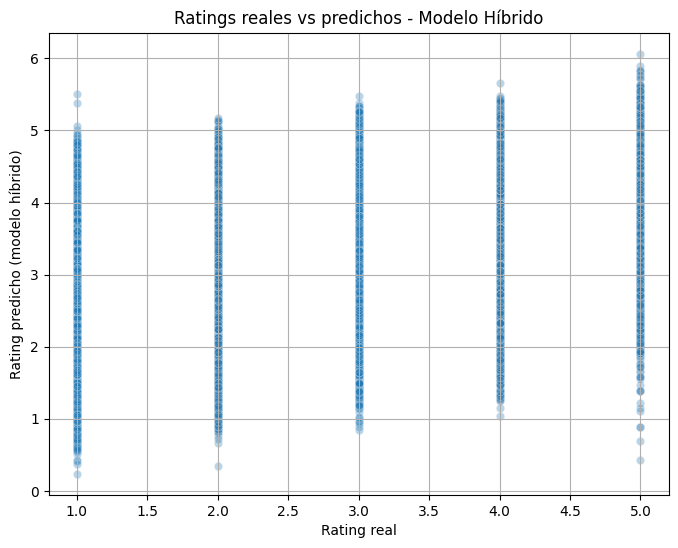

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=hybrid_truth, y=hybrid_preds, alpha=0.3)
plt.xlabel("Rating real")
plt.ylabel("Rating predicho (modelo híbrido)")
plt.title("Ratings reales vs predichos - Modelo Híbrido")
plt.grid(True)
plt.show()
